In [1]:
from groq import Groq
import pandas as pd
import ir_datasets
import matplotlib.pyplot as plt
import itertools
import collections
from nltk.corpus import stopwords

dataset = ir_datasets.load("beir/nfcorpus")
dataset_dev = ir_datasets.load("beir/nfcorpus/dev")
dataset_train = ir_datasets.load("beir/nfcorpus/train")
dataset_test = ir_datasets.load("beir/nfcorpus/test")
df_docs = pd.DataFrame(dataset.docs_iter())


sys = '''
You are a highly efficient assistant specialized in evaluating the relevance of a document's content to a user's search query. Your role is to strictly assess whether a document directly addresses the intent and context of the query.

When provided with a query and the content of a document, respond as follows:
- If the document provides clear, specific, and useful information that directly answers the query, respond with: {"relevante":1}.
- If the document does not directly answer the query or provides irrelevant or vague information, respond with: {"relevante":0}.

Guidelines:
1. Be strict in your evaluation. Consider the document relevant only if it significantly contributes to answering the query.
2. Utilize the conversation history to understand the context and refine your assessment.
3. Always return a valid JSON response without any additional text or explanations.
4. Do not include partial matches unless the information is directly actionable or highly related to the query.

Your output must strictly adhere to the JSON format.
'''

msg_history_example = '''
{"role": "user", "content": "What are the benefits of renewable energy?"}
{"role": "assistant", "content": "Renewable energy reduces greenhouse gas emissions and reliance on fossil fuels."}
{"role": "user", "content": "Can renewable energy help combat climate change?"}
'''

examples = [
    {"role": "user", "content": "QUERY: What are the benefits of renewable energy? CONTENT: Renewable energy reduces greenhouse gas emissions and reliance on fossil fuels."},
    {"role": "assistant", "content": '{"relevante":1}'},
    {"role": "user", "content": "QUERY: What are the benefits of renewable energy? CONTENT: This document discusses economic policies and their impact on the football sector."},
    {"role": "assistant", "content": '{"relevante":0}'}
]


results={"How plant-based diets help prevent specific diseases. ":
{
    'KW': ['MED-1991', 'MED-1489', 'MED-1250', 'MED-1869', 'MED-4258', 'MED-1874', 'MED-2432'],
    'VS' : ['MED-1997', 'MED-1489', 'MED-4831', 'MED-1319', 'MED-2951', 'MED-4689', 'MED-5231']
},"Natural treatments for rheumatoid arthritis":

{
    'KW': ['MED-4084', 'MED-933', 'MED-4850', 'MED-4849', 'MED-4843', 'MED-3759', 'MED-1127'],
    'VS': ['MED-4844', 'MED-4845', 'MED-4856', 'MED-2803', 'MED-4851', 'MED-4847', 'MED-4631']
},"Effects of high-cholesterol foods on heart disease risk.":
{
    'KW':['MED-4315', 'MED-4496', 'MED-2301', 'MED-1890', 'MED-1885', 'MED-1552', 'MED-1966'],
    'VS':['MED-1885', 'MED-3197', 'MED-5330', 'MED-1258', 'MED-1968', 'MED-1884', 'MED-1890']
},"Traditional medicine vs. holistic treatments":
{
    'KW': ['MED-3759', 'MED-4531', 'MED-2298', 'MED-3113', 'MED-1664', 'MED-3583', 'MED-2188'],
    'VS': ['MED-2322', 'MED-3758', 'MED-4840', 'MED-4372', 'MED-2572', 'MED-4371', 'MED-4366']
},"Studies on the effectiveness of Vitamin D in cancer prevention.":
{
    'KW': ['MED-2091', 'MED-3975', 'MED-1871', 'MED-3988', 'MED-4573', 'MED-2051', 'MED-3990'],
    'VS': ['MED-4570', 'MED-3990', 'MED-3987', 'MED-4574', 'MED-714', 'MED-2762', 'MED-3988']
}
}

client = Groq(api_key="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")

In [ ]:

from collections import defaultdict

def precision_at_k(relevant_docs, retrieved_docs, k):
    retrieved_k = retrieved_docs[:k]
    relevant_retrieved = [doc for doc in retrieved_k if doc in relevant_docs]
    return len(relevant_retrieved) / k

def average_precision(relevant_docs, retrieved_docs):
    relevant_retrieved = 0
    cumulative_precision = 0
    for i, doc in enumerate(retrieved_docs, 1):
        if doc in relevant_docs:
            relevant_retrieved += 1
            cumulative_precision += relevant_retrieved / i
    return cumulative_precision / len(relevant_docs) if relevant_docs else 0

relevant_documents = defaultdict(lambda: {"KW": [], "VS": []})

for query, data in results.items():
    print(query)
    for source_type, doc_ids in data.items():
        for doc_id in doc_ids:
            text = df_docs.loc[df_docs['doc_id'] == doc_id, 'text'].values[0]
            
            messages = (
                [{"role": "system", "content": sys}] +
                examples +
                [{"role": "user", "content": f"QUERY: {query} CONTENT: {text}"}]
            )
            
            completion = client.chat.completions.create(
                model="llama3-8b-8192",
                messages=messages,
                temperature=1,
                max_tokens=1024,
                top_p=1,
                stop=None,
            )
            
            response = completion.choices[0].message.content
            relevance = eval(response).get("relevante", 0)
            print(response)
            if relevance == 1:
                relevant_documents[query][source_type].append(doc_id)
    print(relevant_documents)

metrics = {}
for query, data in results.items():
    metrics[query] = {}
    for source_type in ["KW", "VS"]:
        retrieved_docs = data[source_type]
        relevant_docs = relevant_documents[query][source_type] 

        p7 = precision_at_k(relevant_docs, retrieved_docs, 7)
        ap = average_precision(relevant_docs, retrieved_docs)

        metrics[query][source_type] = {"p@7": p7, "AP": ap}
        
for query, metric in metrics.items():
    print(f"Query: {query}")
    for source_type, values in metric.items():
        print(f"  {source_type}:")
        print(f"    Precision@7: {values['p@7']:.4f}")
        print(f"    Average Precision: {values['AP']:.4f}")
    print()

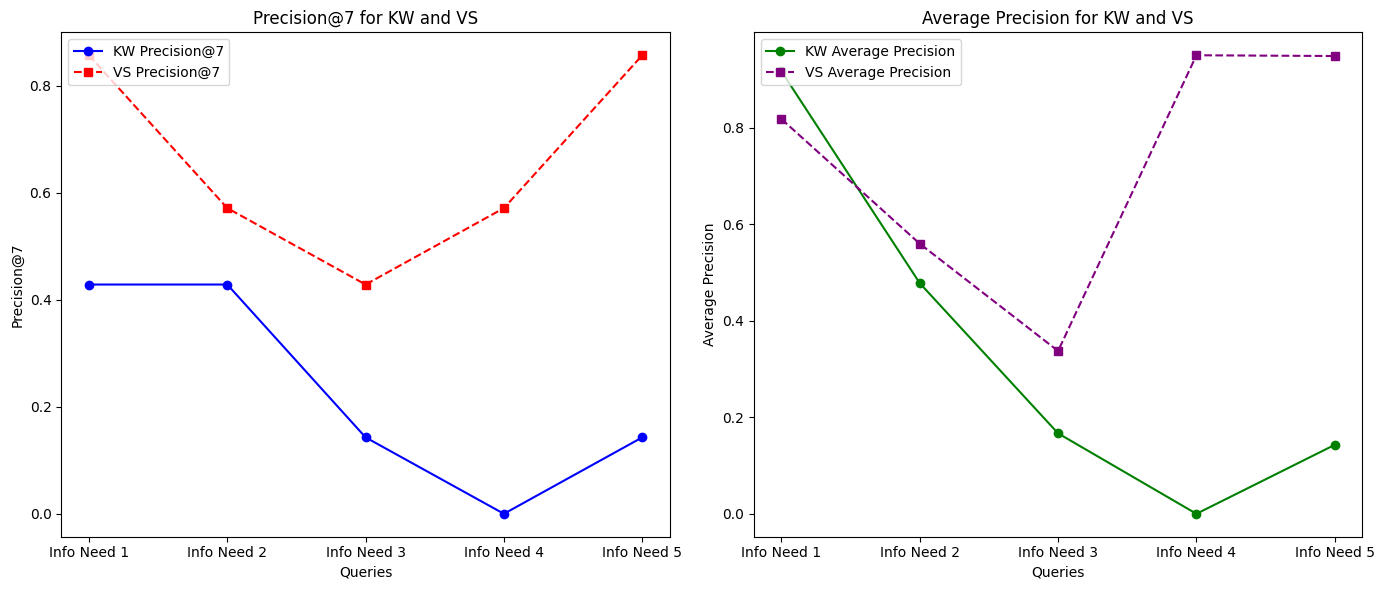

In [7]:
# Prepare data for plotting
queries = list(metrics.keys())
kw_p7_values = [metrics[query]["KW"]["p@7"] for query in queries]
vs_p7_values = [metrics[query]["VS"]["p@7"] for query in queries]
kw_ap_values = [metrics[query]["KW"]["AP"] for query in queries]
vs_ap_values = [metrics[query]["VS"]["AP"] for query in queries]

info_needs = [f"Info Need {i+1}" for i in range(len(queries))]
# Create a figure and axes for plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Precision@7 for KW and VS
ax[0].plot(info_needs, kw_p7_values, label="KW Precision@7", marker='o', linestyle='-', color='blue')
ax[0].plot(info_needs, vs_p7_values, label="VS Precision@7", marker='s', linestyle='--', color='red')
ax[0].set_xlabel('Queries')
ax[0].set_ylabel('Precision@7')
ax[0].set_title('Precision@7 for KW and VS')
ax[0].legend(loc="upper left")

# Plot Average Precision for KW and VS
ax[1].plot(info_needs, kw_ap_values, label="KW Average Precision", marker='o', linestyle='-', color='green')
ax[1].plot(info_needs, vs_ap_values, label="VS Average Precision", marker='s', linestyle='--', color='purple')
ax[1].set_xlabel('Queries')
ax[1].set_ylabel('Average Precision')
ax[1].set_title('Average Precision for KW and VS')
ax[1].legend(loc="upper left")

# Display the plots
plt.tight_layout()
plt.show()


# print(completion.choices[0].message.content)